# Animal Identification
***
## Table of Contents
***

In [3]:
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt

In [ ]:
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "dog": "cane",
    "cavallo": "horse",
    "elephant": "elefante",
    "butterfly": "farfalla",
    "chicken": "gallina",
    "cat": "gatto",
    "cow": "mucca",
    "spider": "ragno",
    "squirrel": "scoiattolo",
}

In [7]:
data_path = Path("_datasets/animal-10/raw-img")

if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"{data_path} Directory does not exist !")

_datasets/animal-10/raw-img directory exists.


In [9]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames, in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
walk_through_dir(data_path)

There are 10 directories and 0 images in _datasets/animal-10/raw-img
There are 0 directories and 3098 images in _datasets/animal-10/raw-img/gallina
There are 0 directories and 4821 images in _datasets/animal-10/raw-img/ragno
There are 0 directories and 1668 images in _datasets/animal-10/raw-img/gatto
There are 0 directories and 2112 images in _datasets/animal-10/raw-img/farfalla
There are 0 directories and 1866 images in _datasets/animal-10/raw-img/mucca
There are 0 directories and 2623 images in _datasets/animal-10/raw-img/cavallo
There are 0 directories and 4863 images in _datasets/animal-10/raw-img/cane
There are 0 directories and 1820 images in _datasets/animal-10/raw-img/pecora
There are 0 directories and 1862 images in _datasets/animal-10/raw-img/scoiattolo
There are 0 directories and 1446 images in _datasets/animal-10/raw-img/elefante


Random image path: _datasets/animal-10/raw-img/cane/OIP-w9_sTNEwp6FSTYtUvm0w-AHaJ6.jpeg
Image class: cane
Image height: 300
Image width: 225


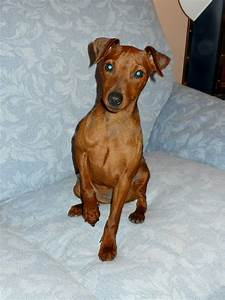

In [12]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(data_path.glob("*/*"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img